In [1]:
import numpy as np
import numpy.ma as ma
import argparse
import sys
sys.path.append("./utils/")
import operator_calculations as op_calc
import delay_embedding as embed
import stats
from scipy.interpolate import UnivariateSpline
from multiprocessing import Pool,cpu_count
import pickle
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import loadmat

In [2]:
params = np.loadtxt('../fluctuating_potential/DW/sims_fpts_tau_s/iteration_eps.txt')
Ts = np.unique(params[0,0])[0]
eps_range = np.unique(params[:,1])
indices = np.array(np.unique(params[:,2]),dtype=int)

In [3]:
f = h5py.File('../data/DW/sims_fpts_tau_s/metadata.h5','r')
Tx = np.array(f['Tx'])[0]
dt = np.array(f['dt'])[0]
maxT = np.array(f['maxT'])[0]
print(f.keys())
f.close()
mu_s = np.sqrt(Tx)

<KeysViewHDF5 ['Tx', 'dt', 'maxT', 'mu_s']>


In [4]:
Ts/Tx

0.4999999762512755

In [5]:
tau_s_range = maxT*eps_range

In [6]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def potential(x,s):
    return s**2*(x**2-1)**2

def exppot(x, Tx,s,sign=-1, fun=lambda z: 1):
    return np.exp(sign*potential(x,s)/Tx)*fun(x)

def omega_be(Tx,s):
    z = np.linspace(-20, 0, 1000)
    iarr = cumtrapz(exppot(z,Tx,s), z, initial=0)
    ifun = interp1d(z, iarr)

    y = np.linspace(-1, 0, 1000)
    oarr = cumtrapz(exppot(y,Tx,s, sign=1, fun=ifun), y, initial=0)/Tx
    ofun = interp1d(y, oarr)
    
    return 1/(2*ofun(0))


fptd_theory = lambda omega,t: omega*np.exp(-omega*t)
omega_Kramers = lambda Tx,s: (2*np.sqrt(2)*s**2/np.pi)*np.exp(-s**2/Tx)

In [8]:
import matplotlib.colors as mcolors
offset = mcolors.TwoSlopeNorm(vmin=np.log10(eps_range[0]),
                                  vcenter=0, vmax=np.log10(eps_range[-1]))
colors_eps = plt.cm.viridis(offset(np.log10(eps_range)))

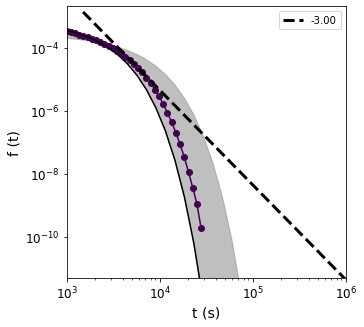

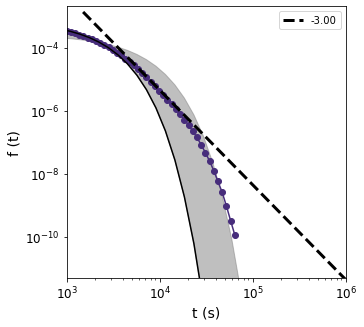

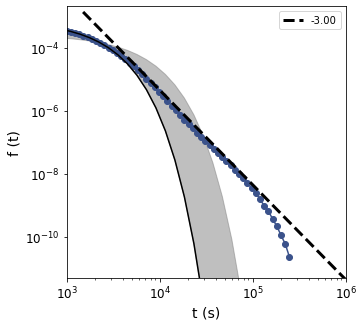

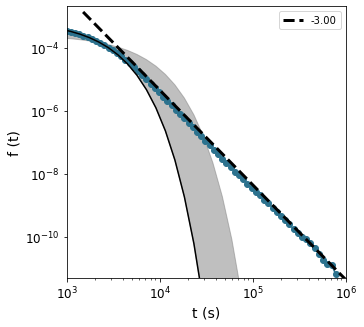

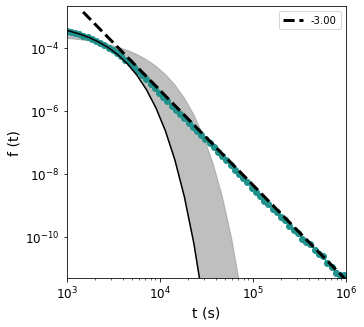

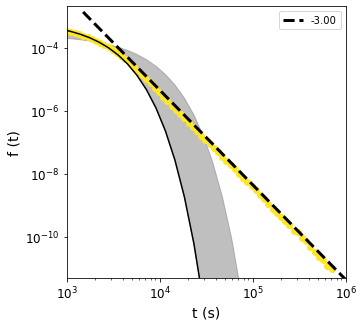

In [9]:
# colors_eps = plt.cm.viridis(np.linspace(0,1,len(eps_range)))
for eps_idx in range(len(eps_range)):
    eps = eps_range[eps_idx]
    f = h5py.File('../data/DW/sims_fpts_tau_s/fptd_eps_idx_{}.h5'.format(eps_idx),'r')
    freqs = np.array(f['freqs'])
    centers_t = np.array(f['centers_t'])
    bins = np.array(f['bins'])
    f.close()
    
    db = np.array(np.diff(bins), float)
    prob = freqs/db/freqs.sum()
    sel = freqs>20
    prob = prob[sel]
    
    plt.figure(figsize=(5,5))
    plt.plot(centers_t[sel],prob,marker='o',c=colors_eps[eps_idx])
    xmin=1.5e3
    trange = np.logspace(np.log10(xmin),6.6)
    alpha = 2+Tx/(2*Ts)
    plt.plot(trange,(alpha-1)/xmin*(trange/xmin)**(-alpha),label = '{:.2f}'.format(-alpha),c='k',ls='--',lw=3)
    
    centers_t = np.logspace(1,6)
    cil = fptd_theory(2*omega_be(Tx,mu_s),centers_t)
    ciu = fptd_theory(2*omega_be(Tx,mu_s+np.sqrt(Ts)),centers_t)
    plt.plot(centers_t,fptd_theory(2*omega_be(Tx,mu_s),centers_t),c='k')
    plt.fill_between(centers_t,cil,ciu,color='.5',alpha=.5)
    plt.legend()
    plt.ylim(5e-12,2e-3)
    plt.xlim(1e3,1e6)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('t (s)',fontsize=14)
    plt.ylabel('f (t)',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#     plt.savefig('fpts_eps_{:.4f}_logx.pdf'.format(eps))
    plt.show()

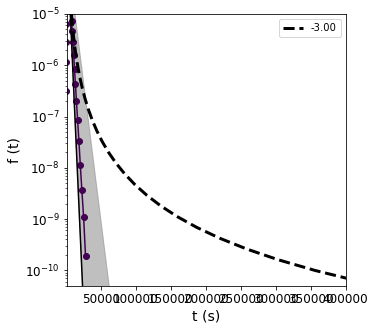

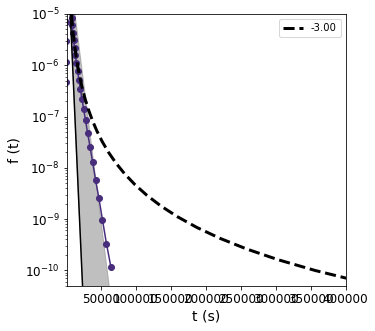

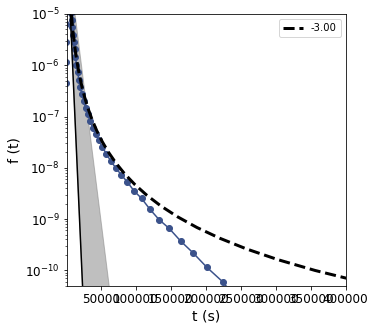

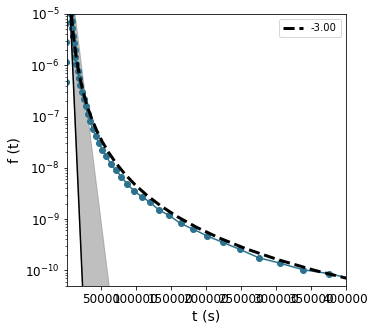

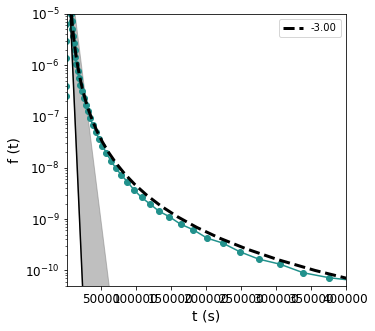

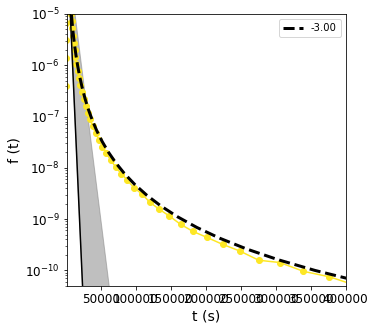

In [10]:
# colors_eps = plt.cm.viridis(np.linspace(0,1,len(eps_range)))
for eps_idx in range(len(eps_range)):
    eps = eps_range[eps_idx]
    f = h5py.File('../data/DW/sims_fpts_tau_s/fptd_eps_idx_{}.h5'.format(eps_idx),'r')
    freqs = np.array(f['freqs'])
    centers_t = np.array(f['centers_t'])
    bins = np.array(f['bins'])
    f.close()
    
    db = np.array(np.diff(bins), float)
    prob = freqs/db/freqs.sum()
    sel = freqs>20
    prob = prob[sel]
    
    plt.figure(figsize=(5,5))
    plt.plot(centers_t[sel],prob,marker='o',c=colors_eps[eps_idx])
    xmin=1.5e3
    trange = np.logspace(np.log10(xmin),6.6)
    alpha = 2+Tx/(2*Ts)
    plt.plot(trange,(alpha-1)/xmin*(trange/xmin)**(-alpha),label = '{:.2f}'.format(-alpha),c='k',ls='--',lw=3)
    
    centers_t = np.logspace(1,6)
    cil = fptd_theory(2*omega_be(Tx,mu_s),centers_t)
    ciu = fptd_theory(2*omega_be(Tx,mu_s+np.sqrt(Ts)),centers_t)
    plt.plot(centers_t,fptd_theory(2*omega_be(Tx,mu_s),centers_t),c='k')
    plt.fill_between(centers_t,cil,ciu,color='.5',alpha=.5)
    plt.legend()
    plt.ylim(5e-11,1e-5)
    plt.xlim(1e3,4e5)
#     plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('t (s)',fontsize=14)
    plt.ylabel('f (t)',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
#     plt.savefig('fpts_eps_{:.4f}.pdf'.format(eps))
    plt.show()

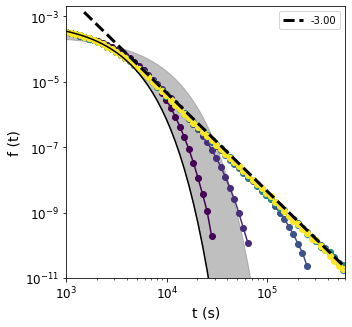

In [10]:
plt.figure(figsize=(5,5))
# colors_eps = plt.cm.viridis(np.linspace(0,1,len(eps_range)))
for eps_idx in range(len(eps_range)):
    eps = eps_range[eps_idx]
    f = h5py.File('/bucket/StephensU/antonio/BehaviorModel/fluctuating_potential/DW/sims_fpts_tau_s_single_Ts/fptd_eps_idx_{}.h5'.format(eps_idx),'r')
    freqs = np.array(f['freqs'])
    centers_t = np.array(f['centers_t'])
    bins = np.array(f['bins'])
    f.close()
    
    db = np.array(np.diff(bins), float)
    prob = freqs/db/freqs.sum()
    sel = freqs>20
    prob = prob[sel]
    
    
    plt.plot(centers_t[sel],prob,marker='o',c=colors_eps[eps_idx])
xmin=1.5e3
trange = np.logspace(np.log10(xmin),6.6)
alpha = 2+Tx/(2*Ts)
plt.plot(trange,(alpha-1)/xmin*(trange/xmin)**(-alpha),label = '{:.2f}'.format(-alpha),c='k',ls='--',lw=3)

cil = fptd_theory(2*omega_be(Tx,mu_s),centers_t[sel])
ciu = fptd_theory(2*omega_be(Tx,mu_s+np.sqrt(Ts)),centers_t[sel])
plt.plot(centers_t[sel],fptd_theory(2*omega_be(Tx,mu_s),centers_t[sel]),c='k')
plt.fill_between(centers_t[sel],cil,ciu,color='.5',alpha=.5)
plt.legend()
plt.ylim(1e-11,2e-3)
plt.xlim(1e3,6e5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (s)',fontsize=14)
plt.ylabel('f (t)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('fpts_eps_all_logx.pdf')
plt.show()

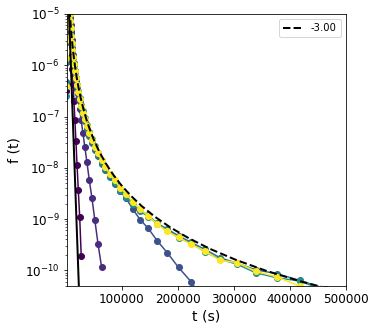

In [11]:
plt.figure(figsize=(5,5))

# colors_eps = plt.cm.viridis(np.linspace(0,1,len(eps_range)))
for eps_idx in range(len(eps_range)):
    eps = eps_range[eps_idx]
    f = h5py.File('../data/DW/sims_fpts_tau_s/fptd_eps_idx_{}.h5'.format(eps_idx),'r')
    freqs = np.array(f['freqs'])
    centers_t = np.array(f['centers_t'])
    bins = np.array(f['bins'])
    f.close()
    
    db = np.array(np.diff(bins), float)
    prob = freqs/db/freqs.sum()
    sel = freqs>20
    prob = prob[sel]
    plt.plot(centers_t[sel],prob,marker='o',c=colors_eps[eps_idx])
xmin=1.5e3
trange = np.logspace(np.log10(xmin),6.6)
alpha = 2+Tx/(2*Ts)
plt.plot(trange,(alpha-1)/xmin*(trange/xmin)**(-alpha),label = '{:.2f}'.format(-alpha),c='k',ls='--',lw=2)
    
centers_t = np.logspace(1,6)
cil = fptd_theory(2*omega_be(Tx,mu_s),centers_t)
ciu = fptd_theory(2*omega_be(Tx,mu_s+np.sqrt(Ts)),centers_t)
plt.plot(centers_t,fptd_theory(2*omega_be(Tx,mu_s),centers_t),c='k',lw=2)
# plt.fill_between(centers_t,cil,ciu,color='.5',alpha=.5)
plt.legend()
plt.ylim(5e-11,1e-5)
plt.xlim(2e3,5e5)
#     plt.xscale('log')
plt.yscale('log')
plt.xlabel('t (s)',fontsize=14)
plt.ylabel('f (t)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('fpts_eps_all_no_errorbar.pdf')
plt.show()

<ipython-input-12-395128fec020>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


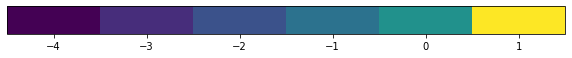

In [12]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_eps)
cmap.set_over('0.')
cmap.set_under('1.0')

log_eps_range = np.log10(eps_range)
bounds =  np.hstack([log_eps_range-np.diff(log_eps_range)[0]/2,log_eps_range[-1]+np.diff(log_eps_range)[0]/2])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=log_eps_range,
                                spacing='proportional',
                                orientation='horizontal')
# plt.savefig('colorbar_eps_range.pdf')
fig.show()


In [13]:
dts_eps = []
idx=0
for eps in eps_range:
    dts=[]
    for k in indices:
        f = h5py.File('../data/DW/sims_fpts_tau_s/combined_results_{}.h5'.format(idx),'r')
        fpts = np.array(f['fpts'])
        f.close()
        dts.append(fpts)
        idx+=1
    dts_eps.append(np.hstack(dts))